# Intro to Rectified Linear Unit

*Based on this blog: [A Gentle Introduction to the Rectified Linear Unit (ReLU)](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)*

*Also includes experiments based on the [03_penguin_neural_classifier](/notebooks/03_penguin_neural_classifier.ipynb) notebook.* 

ReLU is a very simple function defined as $ relu(x) = max(x, 0) $. It is often used as an activation function for neural networks. 

## BUT WHY?

We are going to explore this topic.

<br/>
<details>
    <summary><b>Spoiler</b></summary>
  The question turned out to be surprisingly important. It is related to the roots of deep-learning field (which sounds insane to me). Investigating this topic is very useful for understanding evolution of deep-learning techniques.
</details>

## Plot

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

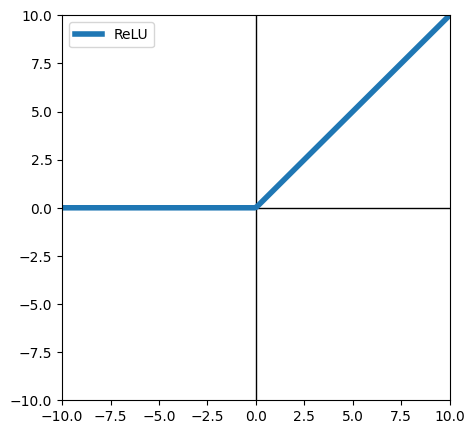

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

x = tf.linspace(-10, 10, 200)

plt.figure(figsize=(5, 5))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)
plt.plot(x, tf.nn.relu(x), label="ReLU", linewidth=4)
plt.ylim((-10, 10))
plt.xlim((-10, 10))
plt.legend()
plt.show()

# Experiment

Firts let's experiment with penguin classification problem. Lets parametrize the problem by the activation function.

## Data

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)
data_test, data_train = dataset
test_batches = data_test.batch(32)
train_batches = data_train.batch(32)

**NOTE** on the `split=['train[:20%]', 'train[20%:]'` argument. 

This is a [Slicing API](https://www.tensorflow.org/datasets/splits) notation. This is the same as Python slicing notation `seq[:n]` with the only difference that besides absolute values, `n` could be a percentage of the entire collection e.g. `train[20%:]`.

## Define Parametrized Experiment

In [4]:
from dataclasses import dataclass, field
from typing import Sequence

def preview(func, name):
    x = tf.linspace(-10, 10, 200)
    plt.figure(figsize=(5, 5))
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)
    plt.plot(x, func(x), label=name, linewidth=4)
    plt.ylim((-10, 10))
    plt.xlim((-10, 10))
    plt.legend()
    plt.show()

def make_model(activation, inner_layers=1, size=10):
    layers = [tf.keras.layers.Dense(size, activation=activation, input_shape=(4,))]
    for _ in range(inner_layers):
        layers.append(tf.keras.layers.Dense(size, activation=activation))
    layers.append(tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax))
    return tf.keras.Sequential(layers)

def calc_gradient(model, inputs, outputs, loss_func):
    with tf.GradientTape() as tape:
        loss_value = loss_func(
            y_true=outputs,
            y_pred=model(inputs),
        )
    gradient = tape.gradient(loss_value, model.trainable_variables)
    return loss_value, gradient

@dataclass
class LearningHistory:
    loss: Sequence[float] = field(default_factory=list)
    accuracy: Sequence[float] = field(default_factory=list)
    
    @property
    def epochs(self) -> int:
        return min(len(self.loss), len(self.accuracy))

    def draw(self):
        epochs = len(self.loss)
        plt.plot(range(epochs), self.loss, label="Loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(epochs), self.accuracy, label="Accuracy")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()
        
def train(model, train_batches, loss, optimizer, epochs=200) -> LearningHistory:
    history = LearningHistory()
    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        for inputs, outputs in train_batches:
            l, gradients = calc_gradient(model, inputs, outputs, loss)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            epoch_loss_avg.update_state(l)
            epoch_accuracy.update_state(outputs, model(inputs, training=True))
        history.loss.append(epoch_loss_avg.result())
        history.accuracy.append(epoch_accuracy.result())
    return history

@dataclass
class Result:
    history: LearningHistory
    accuracy: float
    model: tf.keras.Sequential
        
def evaluate(model, test_batches) -> float:
    accuracy = tf.keras.metrics.Accuracy()
    for inputs, outputs in test_batches:
        prediction = tf.math.argmax(model(inputs), axis=1, output_type=tf.int64)
        accuracy(prediction, outputs)
    return accuracy.result().numpy()

def experiment(activation, train_batches, test_batches, epochs=300, loss=None, optimizer=None, size=10, inner_layers=1) -> Result:
    loss = loss or tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = optimizer or tf.keras.optimizers.SGD(learning_rate=0.01)
    model = make_model(activation, inner_layers=inner_layers, size=size)
    history = train(
        model=model,
        train_batches=train_batches,
        loss=loss, 
        optimizer=optimizer,
        epochs=epochs,
    )
    accuracy = evaluate(model, test_batches)
    return Result(history, accuracy, model)


## ReLU

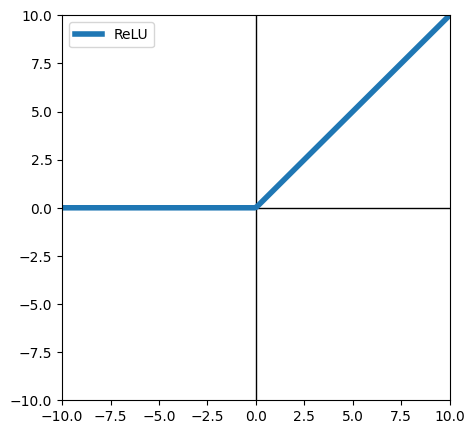

In [5]:
preview(tf.nn.relu, "ReLU")

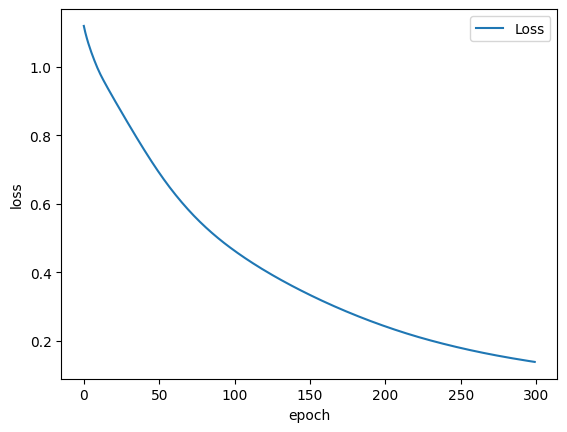

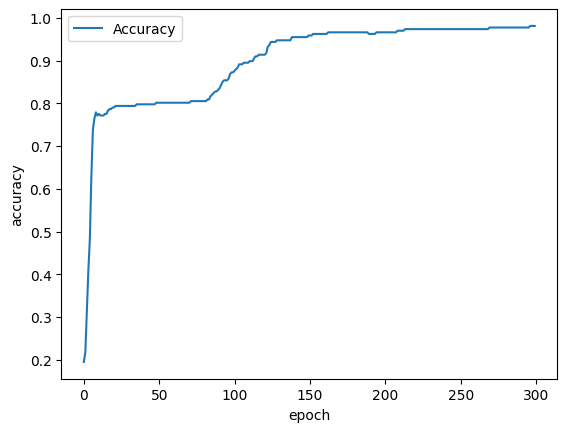

Accuracy: 0.99


In [6]:
relu_result = experiment(tf.nn.relu, train_batches, test_batches)
relu_result.history.draw()
print(f"Accuracy: {relu_result.accuracy:0.2f}")

## tanh

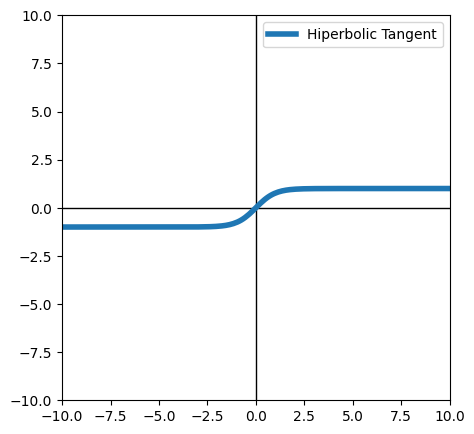

In [7]:
preview(tf.math.tanh, "Hiperbolic Tangent")

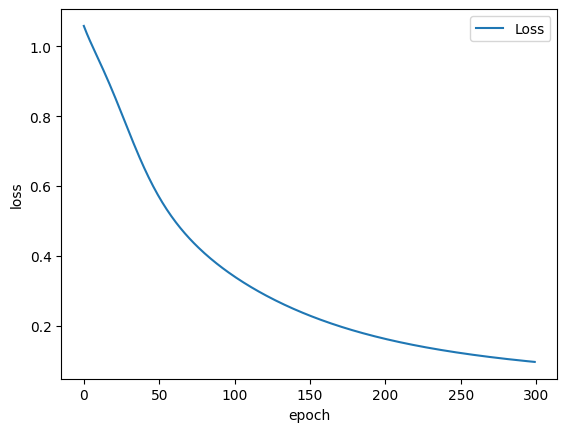

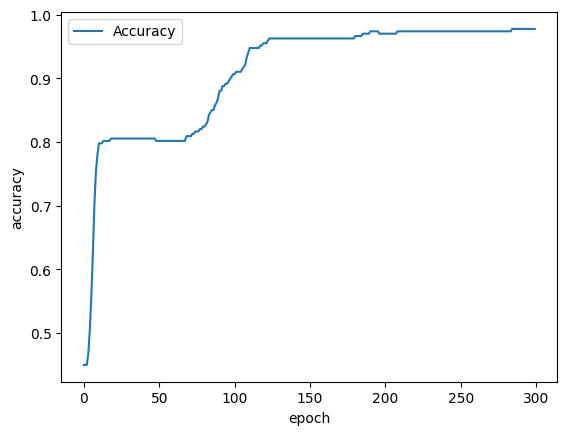

Accuracy: 0.99


In [8]:
result = experiment(tf.math.tanh, train_batches, test_batches)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## sigmoid

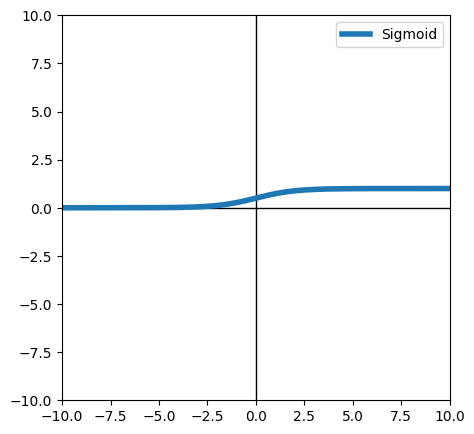

In [9]:
preview(tf.math.sigmoid, "Sigmoid")

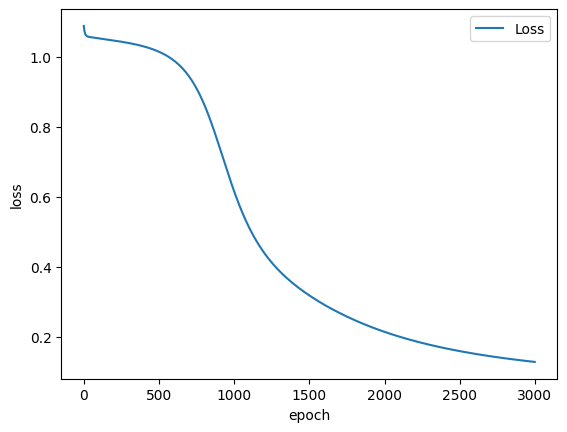

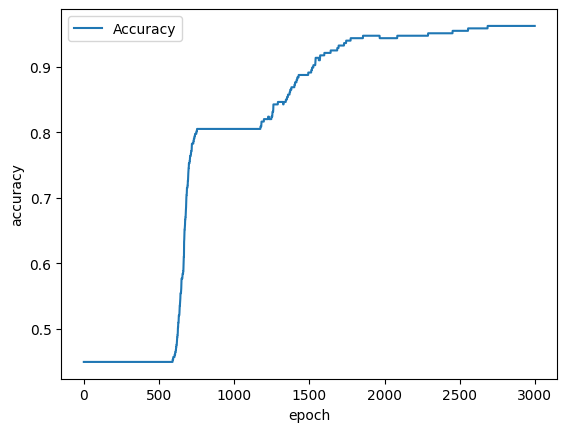

Accuracy: 0.96


In [10]:
result = experiment(tf.math.sigmoid, train_batches, test_batches, epochs=3000)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## gelu

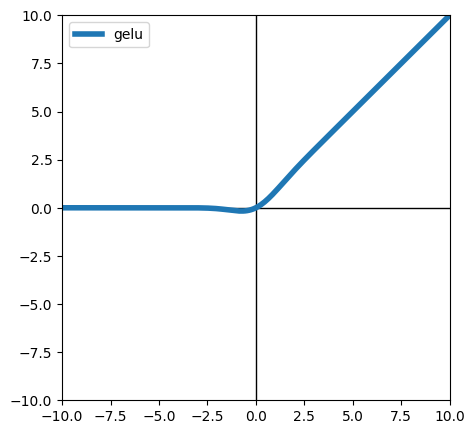

In [11]:
preview(tf.nn.gelu, "gelu")

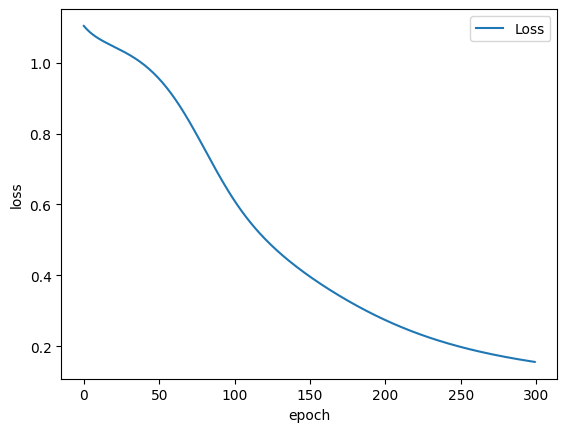

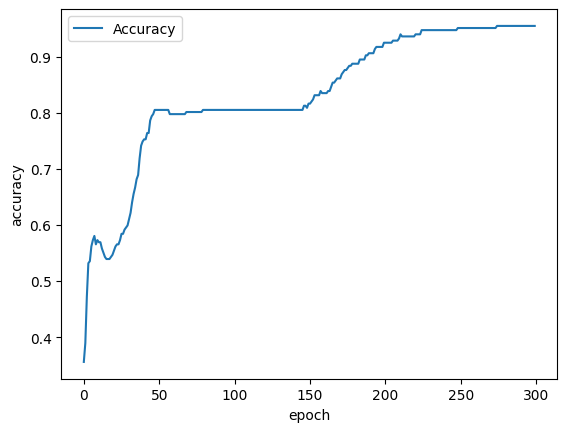

Accuracy: 0.97


In [12]:
result = experiment(tf.nn.gelu, train_batches, test_batches)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## Custom

Let's try a custom function:

$$ 
act = \begin{cases}
    e^x &\text{if x < 0,} \\
    x &\text{otherwise}
\end{cases}
$$


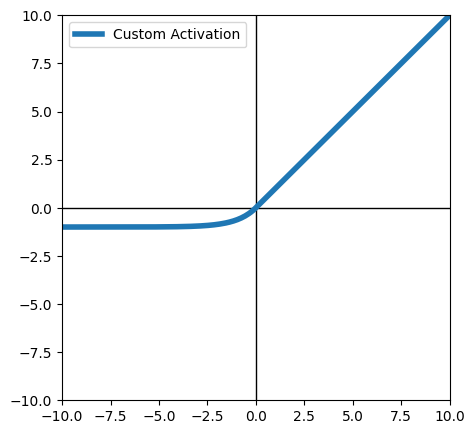

In [13]:
@tf.function
def custom_act(x):
    neg = x < 0
    return tf.cast(neg, x.dtype)*tf.exp(x) + tf.cast(~neg, x.dtype)*(x + 1) - 1

preview(custom_act, "Custom Activation")

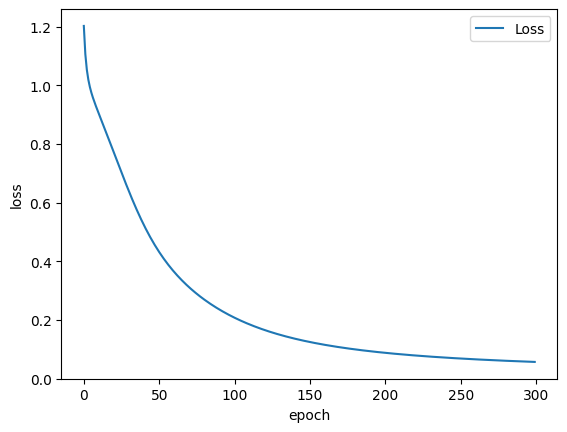

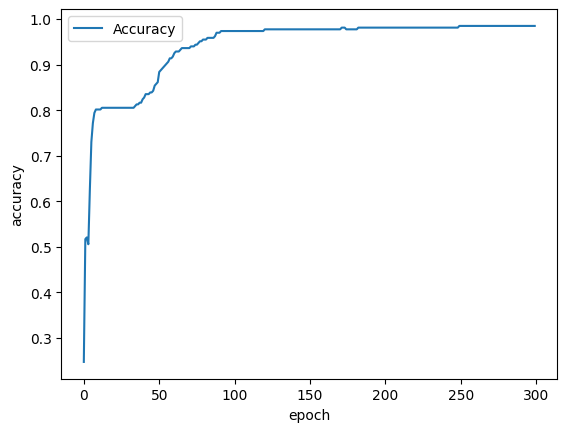

Accuracy: 0.99


In [14]:
result = experiment(custom_act, train_batches, test_batches)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## Discussion

Well, on this simplistic task, I don't see any significant advantage of any activation function over the others. The $tanh(x)$ performs a little batter, but overall all activation function are very good (~99% accuracy). 

The only exception is $sigmoid(x)$ which performs very poorly. Why? Most likely it is not possible to fit the data using this activation function (the model is not flexible enough). Other, less likely explanation is that with `sigmoid` there are some problems in learning the training set. (**UPD**: After a bit of experimentation, I've found out, that `sigmoid` also achieves a high accuracy (~0.97), but it learns *10 times slower*!)

<img src="https://st2.depositphotos.com/1004472/9581/v/950/depositphotos_95814642-stock-illustration-sketch-of-thinking-man.jpg" width="200" />

### **So what's the difference?..**

...


# Historical Note


# Advantages

## Sparsity

![sparse-representation](./docs/ReLU_sparsity.png)

# Fixing Vanishing Gradients with ReLU

This experiment is based on the following article: [How to Fix the Vanishing Gradients Problem Using the ReLU](https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/) by **Jason Brownlee**, Jan 11, 2019

## Create Data

In [4]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from numpy import where
from matplotlib.axes import Axes


class Dataset:
    def __init__(self, samples=1000, noise=0.1):
        self.samples = samples
        self.noise = noise
        self.x, self.y = self._make()
        
    def _make(self):
        return make_circles(n_samples=self.samples, noise=self.noise, random_state=42)
    
    def update(self, samples=None, noise=None):
        if samples is not None:
            self.samples = samples
        if noise is not None:
            self.noise  = noise
        self.x, self.y = self._make()
        
    def draw(self, axes: Axes):
        first = where(self.y == 0)
        second = where(self.y == 1)
        axes.scatter(self.x[first, 0], self.x[first, 1], label="Class = 0", alpha=0.5)
        axes.scatter(self.x[second, 0], self.x[second, 1], label="Class = 1", alpha=0.5)
        axes.legend()
        
    def normalize(self):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        self.x = scaler.fit_transform(self.x)
        
    def split(self, ratio=0.5):
        dataset.normalize()
        n_train = int(dataset.samples * ratio)
        train_x, test_x = dataset.x[:n_train], dataset.x[n_train:]
        train_y, test_y = dataset.y[:n_train], dataset.y[n_train:]
        return (train_x, train_y), (test_x, test_y)


dataset = Dataset()

### Make Dataset Interactive (just for fun)

Implementation notes:
* Adding an enclosing `VBox` eliminates flickering. See [Refresh Output widget with matplotlib figure](https://github.com/jupyter-widgets/ipywidgets/issues/1940)
* Adding a numeric argument like `plt.figure(1)` eliminates unwanted rendering of the plot. See: [How to hide a figure from being shown in Matplotlib in Python](https://www.adamsmith.haus/python/answers/how-to-hide-a-figure-from-being-shown-in-matplotlib-in-python)

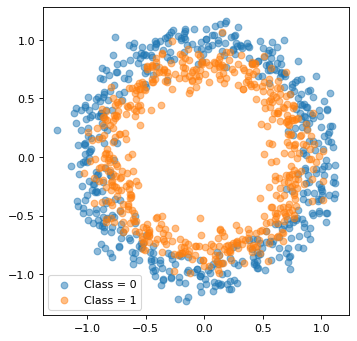

In [5]:
from typing import Dict
import ipywidgets as widgets
from ipywidgets import Output
from IPython.display import display, clear_output

class UIDatasetBuilder:
    """UI for configuring dataset."""
    def __init__(self, dataset: Dataset = None):
        self.dataset: Dataset = dataset or Dataset()
        self.axes: Axes = self._make_axes()
        self._samples: widgets.IntSlider = widgets.IntSlider(min=100, max=3000, description="Samples", value=dataset.samples, step=1)
        self._noise: widgets.FloatSlider = widgets.FloatSlider(min=0.0, max=0.5, description="Noise", value=dataset.noise, step=0.005)
        self.output: widgets.VBox = widgets.VBox(children=[])
        
        self._samples.observe(self._on_samples_change, names='value')
        self._noise.observe(self._on_noise_change, names='value')
        
    def display(self):
        self.axes.clear()
        self.dataset.draw(self.axes)
        output = Output()
        with output:
            clear_output(wait=True)
            display(self.axes.figure)
        self.output.children = [self._samples, self._noise, output]

    def _on_samples_change(self, change: Dict):
        self.dataset.update(samples=change['new'])
        self.display()
        
    def _on_noise_change(self, change: Dict):
        self.dataset.update(noise=change['new'])
        self.display()
    
    @staticmethod
    def _make_axes():
        fig = plt.figure(2, figsize=(5, 5), dpi=80)
        axes = fig.gca()
        axes.set_aspect('equal', adjustable='box')
        return axes
        

builder = UIDatasetBuilder(dataset)
builder.display()
display(builder.output)

In [34]:
import numpy as np
import random

def make_grid_2d(x_limits, y_limits, num):
    x_min, x_max = x_limits
    y_min, y_max = y_limits
    bottom = tf.linspace([x_min, y_min], [x_max, y_min], num=num, axis=0)
    top = tf.linspace([x_min, y_max], [x_max, y_max], num=num, axis=0)
    return tf.linspace(bottom, top, num=num, axis=0)


def show_model(model, dataset):
    x_range = (-1, 1)
    y_range = (-1, 1)
    grid = make_grid_2d(x_range, y_range, 100)
    image = tf.constant(np.array([-model(row).numpy() for row in grid]))
    plt.imshow(image, extent=x_range + y_range)
    dataset.draw(plt.gca())
    plt.show()
    image = tf.constant(np.array([model(row).numpy() for row in grid]))
    plt.imshow(image, extent=x_range + y_range)
    dataset.draw(plt.gca())
    plt.show()
    
def show_activation(model, data):
    extractor = keras.Model(
        inputs=model.inputs,
        outputs=[layer.output for layer in model.layers[:-1]]
    )
    plt.imshow(tf.concat(extractor(tf.constant(tf.constant([data]))), axis=0))
    plt.show()
    
def map_space(model):
    x_range = (-1, 1)
    y_range = (-1, 1)
    grid = make_grid_2d(x_range, y_range, 100)
    image = tf.constant(np.array([model(row).numpy() for row in grid]))
    return image

class HistoryUI:
    def __init__(self, history):
        self.history = history
        self.epochs = len(history.history['space'])
        self.epoch = self.epochs - 1
        self._epoch_slider: widgets.IntSlider = widgets.IntSlider(min=0, max=self.epochs - 1, description="Epoch", value=self.epoch, step=1)
        self._axes: Axes = self._make_axes()    
        self.output: widgets.VBox = widgets.VBox(children=[])
        
        self._epoch_slider.observe(self._on_epoch_change, names='value')
        
    
    def _draw_space(self, axes):
        x_range = (-1, 1)
        y_range = (-1, 1)
        image = self.history.history['space'][self.epoch]
        axes.imshow(image, extent=x_range + y_range)
        
    def display(self):
        self._axes.clear()
        self._draw_space(self._axes)
        space_output = Output()
        with space_output:
            clear_output(wait=True)
            display(self._axes.figure)
        self.output.children = [self._epoch_slider, space_output]

    def _on_epoch_change(self, change: Dict):
        self.epoch = change['new']
        self.display()
        
    @staticmethod
    def _make_axes():
        fig = plt.figure(int(10**9 * random.random()), figsize=(5, 5), dpi=80)
        axes = fig.gca()
        axes.set_aspect('equal', adjustable='box')
        return axes
        
    @staticmethod
    def show(history):
        ui = HistoryUI(history)
        ui.display()
        display(ui.output)
        

class ActivationPresenter:
    def __init__(self, model):
        self.model = model
        self.extractor = keras.Model(
            inputs=model.inputs,
            outputs=[layer.output for layer in model.layers[:-1]]
        )
        self.x = 0.0
        self.y = 0.0
        
        self._space_axes: Axes = self._make_axes()
        self._act_axes: Axes = self._make_axes()
        self._x_slider: widgets.FloatSlider = widgets.FloatSlider(min=-1.0, max=1.0, description="x", value=self.x, step=0.005)
        self._y_slider: widgets.FloatSlider = widgets.FloatSlider(min=-1.0, max=1.0, description="y", value=self.y, step=0.005)
        self.output: widgets.VBox = widgets.VBox(children=[])
        
        self._x_slider.observe(self._on_x_change, names='value')
        self._y_slider.observe(self._on_y_change, names='value')
        
    def _draw_activation(self, axes, data):
        activation = tf.concat(self.extractor(tf.constant(tf.constant([data]))), axis=0)
        axes.imshow(activation)
    
    def _draw_space(self, axes):
        x_range = (-1, 1)
        y_range = (-1, 1)
        grid = make_grid_2d(x_range, y_range, 100)
        image = tf.constant(np.array([self.model(row).numpy() for row in grid]))
        axes.imshow(image, extent=x_range + y_range)
        axes.scatter([self.x], [self.y])
        
    def display(self):
        self._space_axes.clear()
        self._draw_space(self._space_axes)
        space_output = Output()
        with space_output:
            clear_output(wait=True)
            display(self._space_axes.figure)
            
        
        self._act_axes.clear()
        self._draw_activation(self._act_axes, [self.x, self.y])
        act_output = Output()
        with act_output:
            clear_output(wait=True)
            display(self._act_axes.figure)
        
        self.output.children = [self._x_slider, self._y_slider, space_output, act_output]

    def _on_x_change(self, change: Dict):
        self.x = change['new']
        self.display()
        
    def _on_y_change(self, change: Dict):
        self.y = change['new']
        self.display()
    
    @staticmethod
    def _make_axes():
        fig = plt.figure(int(10**9 * random.random()), figsize=(5, 5), dpi=80)
        axes = fig.gca()
        axes.set_aspect('equal', adjustable='box')
        return axes
        
    @staticmethod
    def present(model):
        presenter = ActivationPresenter(model)
        presenter.display()
        display(presenter.output)

### Define Model

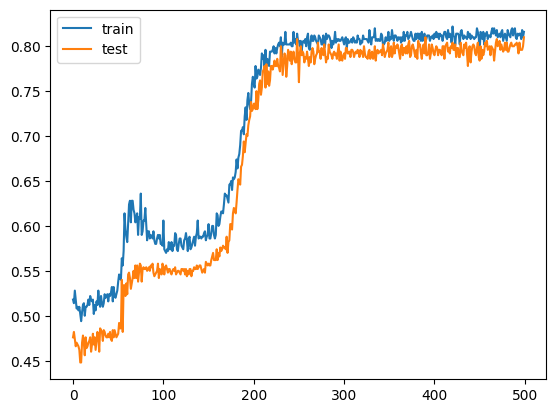

In [24]:
import tensorflow.keras as keras
import keras.initializers as inits
import keras.layers as layers
import keras.activations as acts
import keras.losses as losses
import keras.optimizers as optimizers


class SpaceHistory(keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model
        self.history = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.history.append(map_space(self.model))


def make_model(n_layers, act, size=5, init=lambda:inits.RandomUniform(minval=0, maxval=1)):
    model_layers = [layers.Dense(size, input_dim=2, activation=act, kernel_initializer=init())]
    for _ in range(n_layers - 1):
        model_layers.append(layers.Dense(size, activation=act, kernel_initializer=init(), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),))
    model_layers.append(layers.Dense(1, activation=acts.sigmoid, kernel_initializer=init()))
    return keras.Sequential(model_layers)


def train(
    model, 
    dataset, 
    opt=lambda:optimizers.SGD(learning_rate=0.01, momentum=0.9), 
    loss=lambda:losses.BinaryCrossentropy()
):
    model.compile(loss=loss(), optimizer=opt(), metrics=['accuracy'])
    (train_x, train_y), (test_x, test_y) = dataset.split()
    space_history = SpaceHistory(model)
    history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=500, verbose=0, callbacks=[space_history])
    history.history['space'] = space_history.history
    return history


def draw_results(history):
    plt.plot(history.history['accuracy'], label="train")
    plt.plot(history.history['val_accuracy'], label="test")
    plt.legend()
    plt.show()


model = make_model(n_layers=1, act=acts.tanh)
history = train(model, dataset)
draw_results(history)

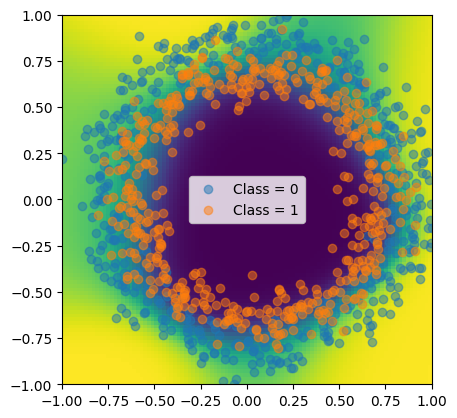

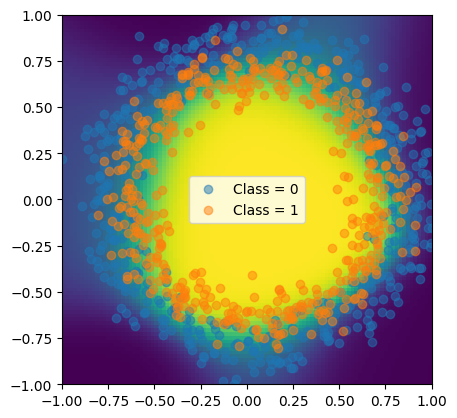

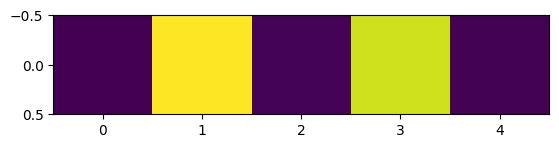

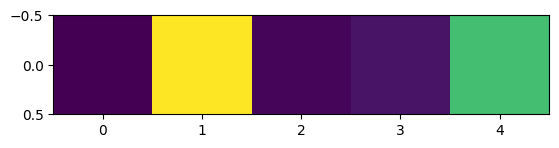

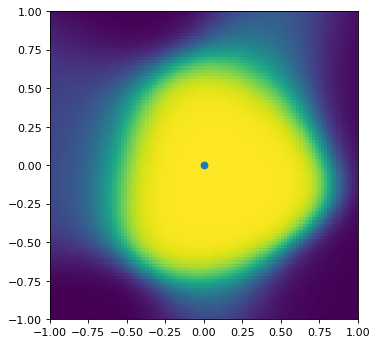

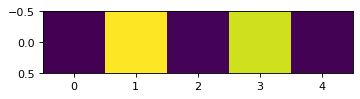

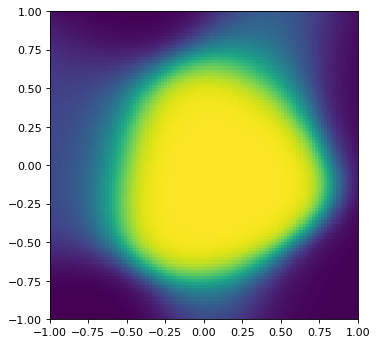

In [35]:
show_model(model, dataset)
show_activation(model, (0.0, 0.0))
show_activation(model, (-1.0, 1.0))
ActivationPresenter.present(model)
HistoryUI.show(history)

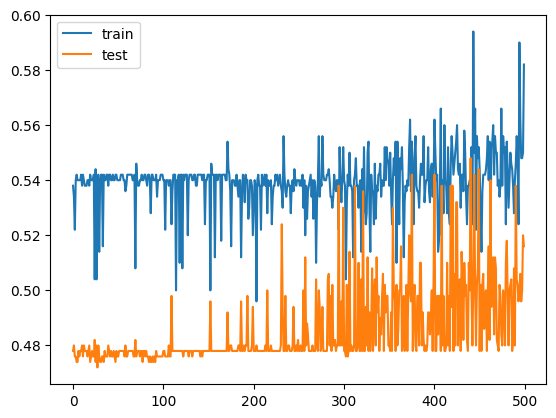

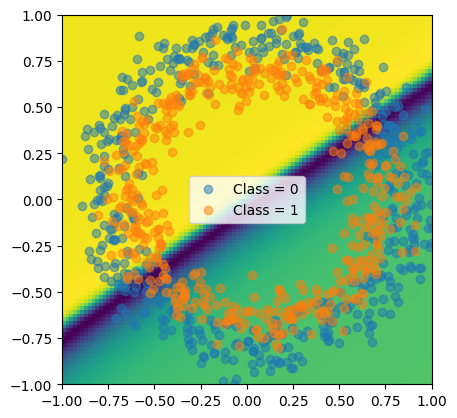

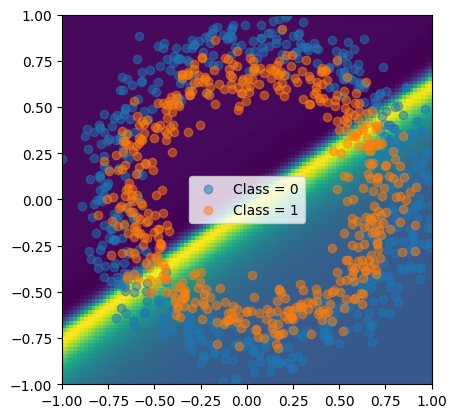

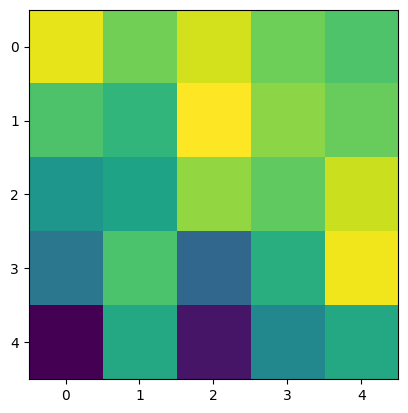

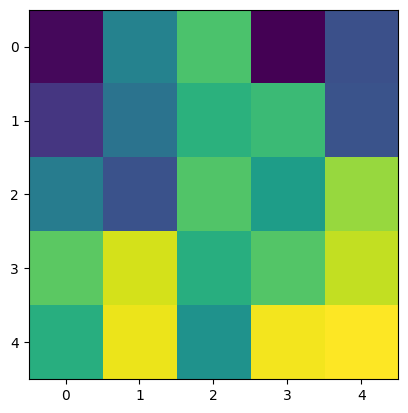

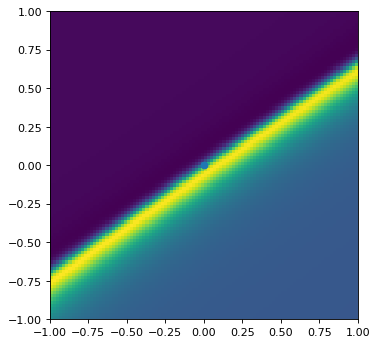

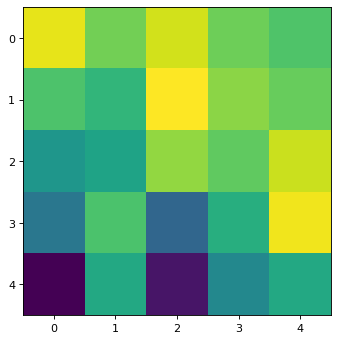

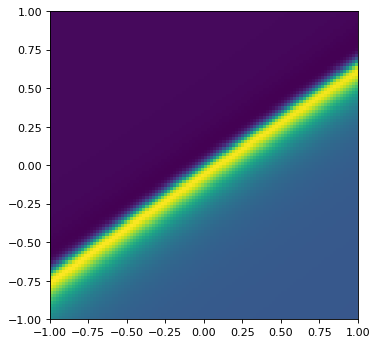

In [36]:
model = make_model(n_layers=5, act=acts.tanh)
history = train(model, dataset)
draw_results(history)
show_model(model, dataset)
show_activation(model, (0.0, 0.0))
show_activation(model, (-1.0, 1.0))
ActivationPresenter.present(model)
HistoryUI.show(history)

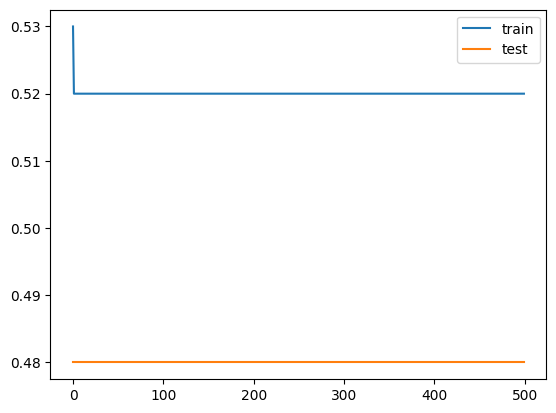

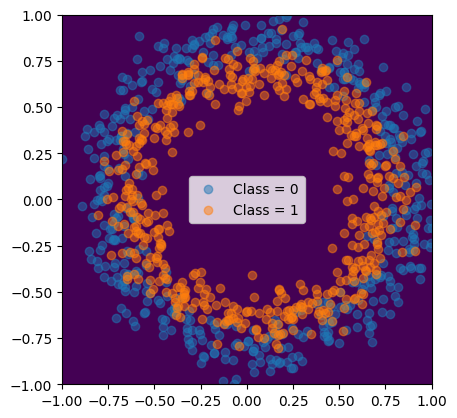

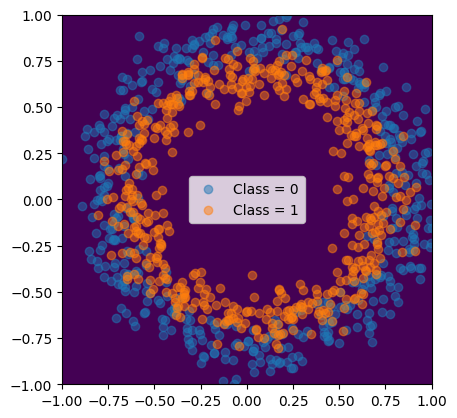

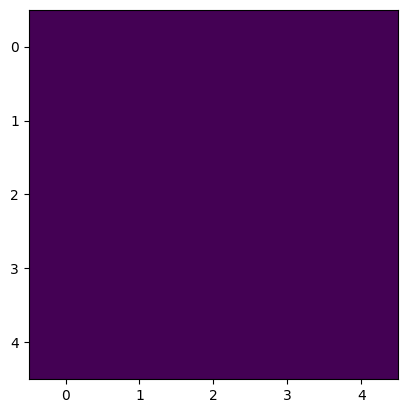

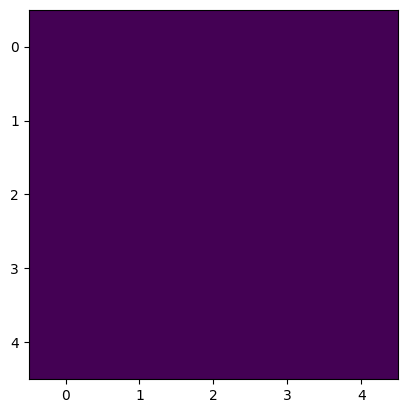

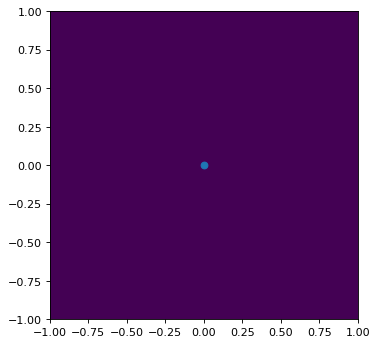

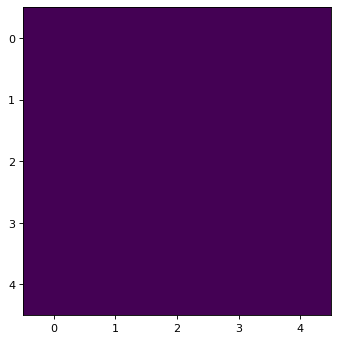

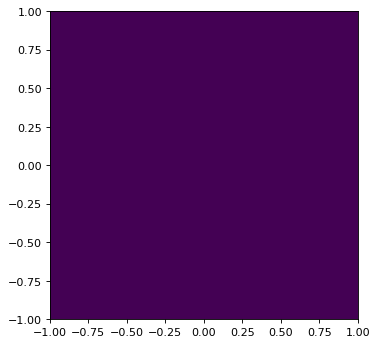

In [37]:
model = make_model(n_layers=5, act=acts.relu)
history = train(model, dataset)
draw_results(history)
show_model(model, dataset)
show_activation(model, (0.0, 0.0))
show_activation(model, (-1.0, 1.0))
ActivationPresenter.present(model)
HistoryUI.show(history)

#### NOTE!!!

`ReLU` activation completely fails with `RandomUniform` initialization.

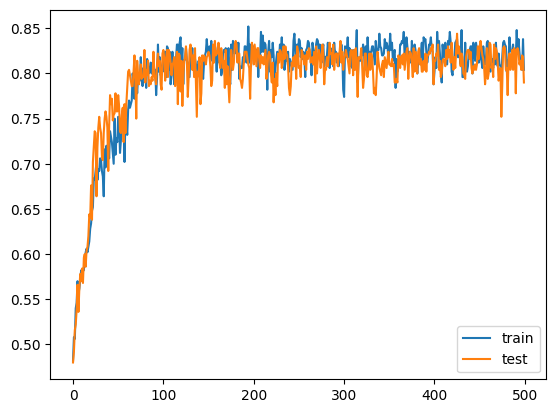

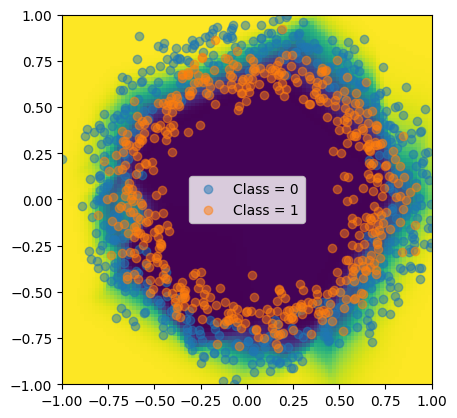

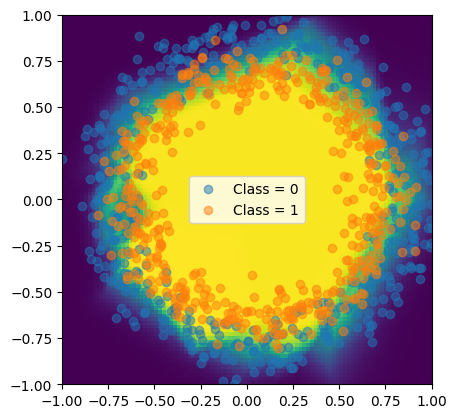

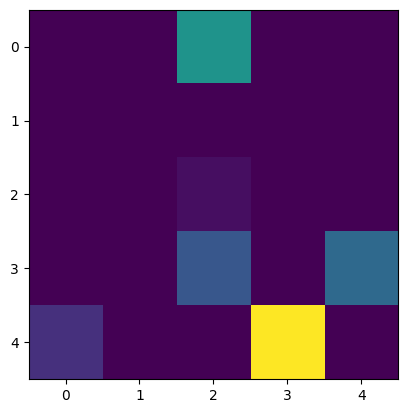

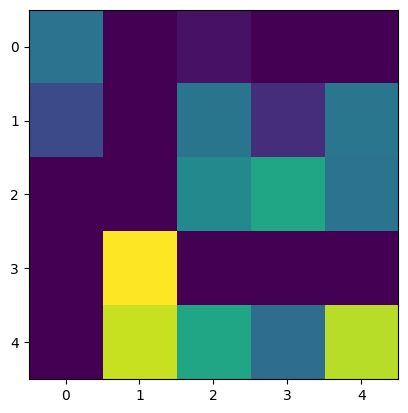

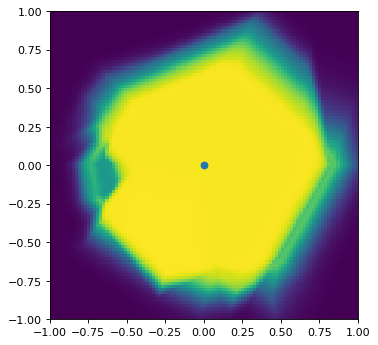

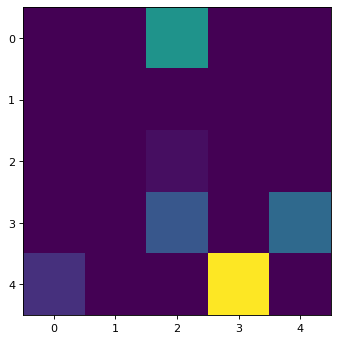

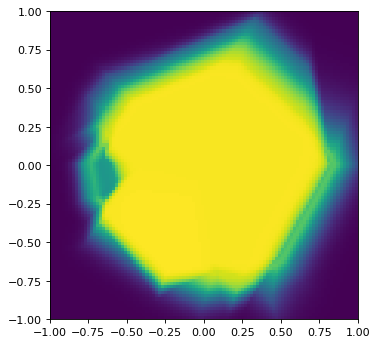

In [38]:
model = make_model(n_layers=5, act=acts.relu, init=inits.HeUniform)
history = train(model, dataset)
draw_results(history)
show_model(model, dataset)
show_activation(model, (0.0, 0.0))
show_activation(model, (-1.0, 1.0))
ActivationPresenter.present(model)
HistoryUI.show(history)

But with He initialization it dominates `tanh`... Why?

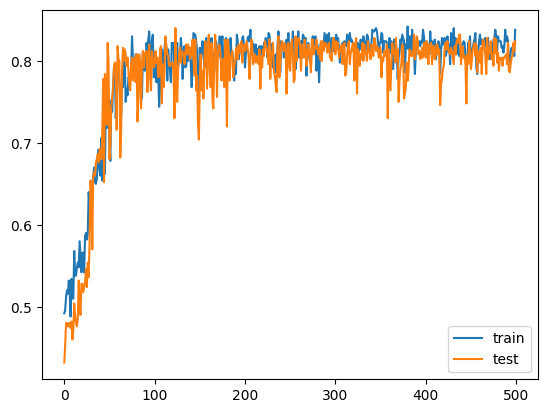

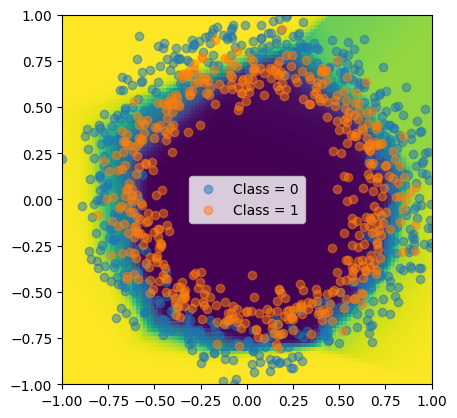

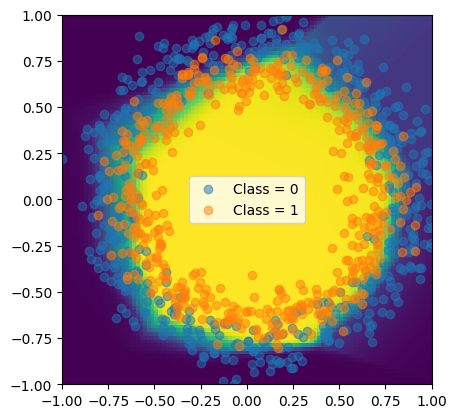

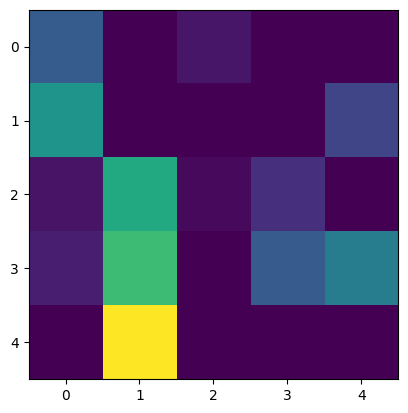

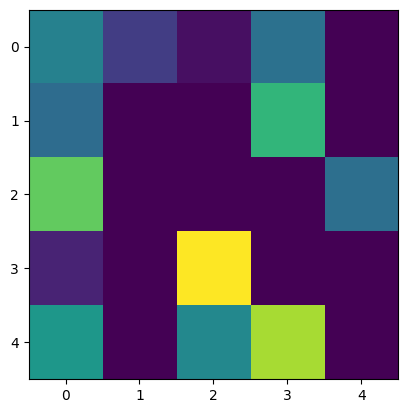

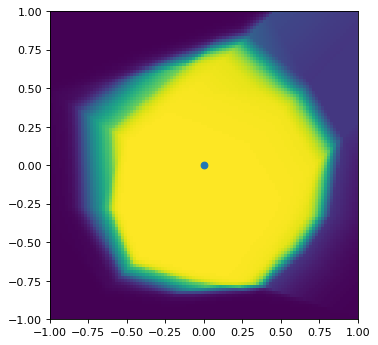

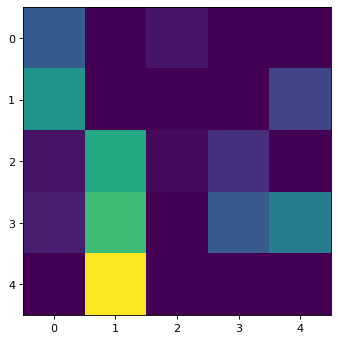

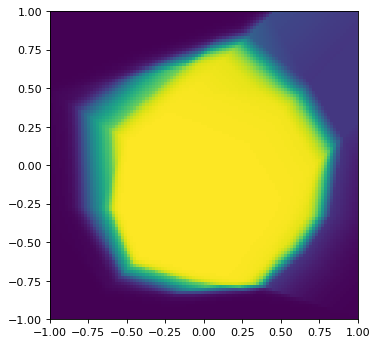

In [39]:
model = make_model(n_layers=5, act=acts.relu, init=lambda:inits.RandomUniform(minval=-1, maxval=1))
history = train(model, dataset)
draw_results(history)
show_model(model, dataset)
show_activation(model, (0.0, 0.0))
show_activation(model, (-1.0, 1.0))
ActivationPresenter.present(model)
HistoryUI.show(history)